In [1]:
!pwd


/mnt/home/eneubeck/GADME


## 1- Loading the model and the dataset

In [2]:
# 1.1 Importe 
# dauert länger

import transformers
import torch

import torch.nn.functional as F
from PIL import Image

import os
import json
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

import torchvision
from torchvision import models
from torchvision import transforms

from torchaudio.transforms import Spectrogram, MelScale

from pytorch_lightning import Callback

from omegaconf import DictConfig

from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import LRP
from captum.attr import Occlusion
from captum.attr import NoiseTunnel
from captum.attr import Saliency
from captum.attr import visualization as viz
from captum.attr._utils.lrp_rules import EpsilonRule, GammaRule, Alpha1_Beta0_Rule

In [41]:
# dauert länger
# !nvidia-smi

In [3]:
print(torch.cuda.is_available())

True


# TLDR Teil des BirdSetTutorial von birdset-pipeline_tutorial.ipynb

In [ ]:
# birdset-pipeline_tutorial.ipynb TLDR Data Module 

print("start")
from birdset.datamodule.base_datamodule import DatasetConfig
from birdset.datamodule.birdset_datamodule import BirdSetDataModule

# initiate the data module
dm = BirdSetDataModule(
    dataset= DatasetConfig(
        data_dir="/mnt/home/eneubeck/data_birdset",
        dataset_name='HSN',
        hf_path='DBD-research-group/BirdSet',
        hf_name='HSN',
        n_classes=21,
        n_workers=3,
        val_split=0.2,
        task="multilabel",
        classlimit=500,
        eventlimit=5,
        sampling_rate=32000,
    ),
)

print("done 1")
# prepare the data (download dataset, ...)
dm.prepare_data()
print("done 2")
# setup the dataloaders
dm.setup(stage="fit")
# get the dataloaders
train_loader = dm.train_dataloader()
# get the first batch
batch = next(iter(train_loader))
# get shape of the batch
print(batch["input_values"].shape)
print(batch["labels"].shape)
batch


In [4]:
# birdset-pipeline_tutorial.ipynb TLDR Trainer
from lightning import Trainer
min_epochs = 1
max_epochs = 5
trainer = Trainer(min_epochs=min_epochs, max_epochs=max_epochs, accelerator="gpu", devices=1)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [5]:
# birdset-pipeline_tutorial.ipynb TLDR Modell

from birdset.modules.base_module import BaseModule
model = BaseModule(
    len_trainset=dm.len_trainset,
    task=dm.task,
    batch_size=dm.train_batch_size,
    num_epochs=max_epochs)

In [ ]:
# model

In [ ]:
# birdset-pipeline_tutorial.ipynb TLDR Trainieren
trainer.fit(model, dm)

You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]

  | Name                  | Type                   | Params
-----------------------------------------------------------------
0 | loss                  | BCEWithLogitsLoss      | 0     
1 | model                 | EfficientNetClassifier | 6.5 M 
2 | train_metric          | cmAP                   | 0     
3 | valid_metric          | cmAP                   | 0     
4 | test_metric           | cmAP                   | 0     
5 | valid_metric_best     | MaxMetric              | 0     
6 | valid_add_metrics     | MetricCollection       | 0     
7 | test_add_metrics      | MetricCollection     

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

# Bisheriger Code (muss noch an TLDR angepasst werden)

In [16]:
# 1.7 get the dataloaders
# Die Variable train_loader ist eine Instanz der Klasse DataLoader. Der DataLoader greift auf die vorverarbeiteten Trainingsdaten zu, welche auf der Festplatte  
# gespeichert sind. Beim Training werden die Daten schrittweise aus der Festplatte geladen und dem Modell über diesen DataLoader 
# zur Verfügung gestellt.
# Der DataLoader ist eine Klasse aus der PyTorch-Bibliothek, die für das effiziente Laden von Daten während des Trainings von NN verwendet wird.

train_loader = datamodule.train_dataloader()
# get the first batch
batch = next(iter(train_loader))

# print("batch[input_values].shape", batch["input_values"].shape)
print("batch[labels].shape", batch["labels"].shape)

batch[labels].shape torch.Size([32, 21])


In [17]:
print("Anzahl der Batches im Train DataLoader:", len(train_loader))

Anzahl der Batches im DataLoader: 449


In [19]:
# print(batch["labels"])
# tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
# jeweils nur ein label pro example hat eine 1

In [40]:
# 1.8 Das erste Beispiel aus dem Dataset erhalten

first_example = batch["input_values"][2]
labels_first_example = batch["labels"][2]
print("first_example", first_example)
print("first_example shape", first_example.shape)
print("labels_first_example", labels_first_example)

# Verwendung von argmax, um den Index des höchsten Werts zu erhalten
top_label_index = torch.argmax(labels_first_example)
print(f"Index des Top-Labels: {top_label_index.item()}")

first_example tensor([[[3.3160, 3.0851, 2.7709,  ..., 4.6749, 3.9908, 4.1617],
         [2.1458, 1.9149, 1.6008,  ..., 3.5048, 2.8206, 2.9915],
         [4.5433, 2.2846, 1.4138,  ..., 2.7860, 2.1522, 1.9523],
         ...,
         [2.0278, 2.0945, 2.1917,  ..., 2.1383, 2.2355, 2.3719],
         [2.7070, 2.6482, 2.4521,  ..., 2.4269, 2.7974, 3.1526],
         [4.2823, 4.4412, 4.8865,  ..., 6.5161, 6.6894, 6.8118]]])
first_example shape torch.Size([1, 128, 1024])
labels_first_example tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.], dtype=torch.float16)
Index des Top-Labels: 3


In [21]:
# 1.9 Kontrolle, ob Abschnitte des Arrays leer sind

first_example_np = first_example.numpy()
first_example_np = np.squeeze(first_example_np)

# Ermitteln des Index, der dem Beginn des letzten Drittels der Zeitachse entspricht
time_dimension = first_example_np.shape[-1]  # Die letzte Dimension sollte die Zeitachse sein
start_of_last_part = time_dimension * 7// 8  # Start bei drei Achteln des Weges

# Teil des Tensors auswählen, der das letzte Teil der Zeitachse abbildet
last_part_of_tensor = first_example_np[..., start_of_last_part:]

# Vollständige Anzeige dieses Abschnitts des Tensors
print(last_part_of_tensor)

# Um zu überprüfen, ob alle Werte gleich sind, einzigartige Werte zählen
unique_values = np.unique(last_part_of_tensor)
print(f"Einzigartige Werte im letzten Teil des Tensors: {unique_values}")

# Wenn die Anzahl der einzigartigen Werte sehr gering ist, deutet dies auf Stille oder fehlende Daten hin
print(f"Anzahl einzigartiger Werte: {len(unique_values)}")

[[4.7239046 6.211537  6.9218397 ... 4.674922  3.990794  4.161696 ]
 [3.5537431 5.0413747 5.7516785 ... 3.5047603 2.8206322 2.9915347]
 [2.7231004 4.355309  4.3779354 ... 2.786008  2.152174  1.9523365]
 ...
 [1.4263905 1.6811389 1.9586685 ... 2.1382594 2.2355099 2.3718686]
 [1.9626096 2.2168193 2.3818107 ... 2.426927  2.7973542 3.1526325]
 [6.493661  6.266138  6.3598084 ... 6.5161424 6.6894345 6.8117595]]
Einzigartige Werte im letzten Teil des Tensors: [-5.876467  -5.849602  -5.5903735 ...  7.267295   7.2738047  7.393135 ]
Anzahl einzigartiger Werte: 16373


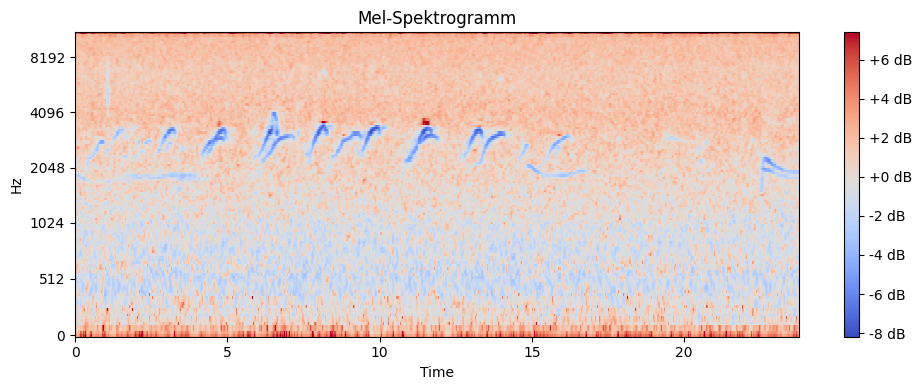

In [74]:
# alt
# 1.10 Spektrogramm - alt

import librosa.display
import matplotlib.pyplot as plt
import numpy as np

def show_spektrogramm(spektrum, titel='Mel-Spektrogramm'):
  plt.figure(figsize=(10, 4))
  librosa.display.specshow(spektrum, y_axis='mel', x_axis='time')
  plt.colorbar(format='%+2.0f dB')
  plt.title(titel)
  plt.tight_layout()
  plt.show()

# Konvertiere den PyTorch-Tensor in ein NumPy-Array
#first_example_np = first_example.numpy()

# Entferne die erste Dimension von ([1, 128, 1397]), da diese nicht benötigt wird:
first_example_np = np.squeeze(first_example_np)

# Rufe die Funktion auf, um das Spektrogramm anzuzeigen
show_spektrogramm(first_example_np)

In [78]:
# 1.10 Spektrogramm

import librosa.display
import matplotlib.pyplot as plt
import numpy as np

def show_spektrogrammm2(spektrum, sample_rate, hop_length, n_fft, titel='Mel-Spektrogramm', cmap="viridis"):
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(spektrum, 
                             y_axis='mel', sr=sample_rate, hop_length=hop_length, n_fft=n_fft,  
                             x_axis='time', cmap=cmap)
    plt.colorbar(format='%+2.0f dB')
    plt.title(titel)
    plt.tight_layout()
    plt.show()



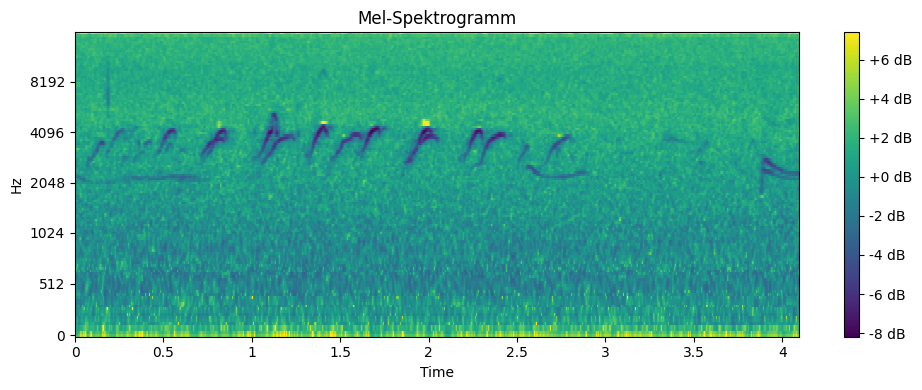

In [79]:
n_fft = 1024
hop_length = 128
sample_rate = 32000

# Konvertiere den PyTorch-Tensor in ein NumPy-Array
first_example_np = first_example.numpy()

# Entferne die erste Dimension von ([1, 128, 1397]), da diese nicht benötigt wird:
first_example_np = np.squeeze(first_example_np)

# Rufe die Funktion auf, um das Spektrogramm anzuzeigen
show_spektrogrammm2(first_example_np, sample_rate=sample_rate, hop_length=hop_length, n_fft=n_fft)

In [25]:
first_example_np.shape

(128, 1024)

In [26]:
# 1.11 Wiederholung: Das erste Beispiel aus dem Dataset erhalten

print(first_example)
print(labels_first_example)
print(f"Index des Top-Labels: {top_label_index.item()}")

tensor([[[3.3160, 3.0851, 2.7709,  ..., 4.6749, 3.9908, 4.1617],
         [2.1458, 1.9149, 1.6008,  ..., 3.5048, 2.8206, 2.9915],
         [4.5433, 2.2846, 1.4138,  ..., 2.7860, 2.1522, 1.9523],
         ...,
         [2.0278, 2.0945, 2.1917,  ..., 2.1383, 2.2355, 2.3719],
         [2.7070, 2.6482, 2.4521,  ..., 2.4269, 2.7974, 3.1526],
         [4.2823, 4.4412, 4.8865,  ..., 6.5161, 6.6894, 6.8118]]])
tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.], dtype=torch.float16)
Index des Top-Labels: 3


In [50]:
model = model.eval()

In [63]:
# 1.12 Modellvorhersage für ein einzelnes Example

import torch
import torch.nn.functional as F

input = first_example.unsqueeze(0)  # fügt neue Dimension an der Position 0 hinzu
# print("input", input)  # input tensor([[[[3.0671, 3.3124, 4.0746,

# Ergebnis der Vorhersage als rohe Ausgabe (Logits)
output = model(input)

# Anwenden der Sigmoid-Funktion, um die rohen Modellausgaben in Wahrscheinlichkeiten zw. 0 und 1 umzuwandeln
# Sigmoid, da es eine Multilabel-Klassifizierung ist, und daher jedes Label einzeln einen Wahrscheinlichkeitswert bekommt
output_sigmoid = torch.sigmoid(output)

# Ermitteln des maximalen Werts und des entsprechenden Indexes
prediction_score, pred_label_idx = torch.max(output_sigmoid, dim=1)

print("Eingabe:", input)
print("Rohe Ausgabe", output)
print("Ausgabe nach Sigmoid:", output_sigmoid)
print("Höchste Vorhersage:", prediction_score)
print("Index des Labels mit der höchsten Vorhersage:", pred_label_idx) 
print(f"Index des Top-Labels aus den Testdaten: {top_label_index.item()}")

Eingabe: tensor([[[[3.3160, 3.0851, 2.7709,  ..., 4.6749, 3.9908, 4.1617],
          [2.1458, 1.9149, 1.6008,  ..., 3.5048, 2.8206, 2.9915],
          [4.5433, 2.2846, 1.4138,  ..., 2.7860, 2.1522, 1.9523],
          ...,
          [2.0278, 2.0945, 2.1917,  ..., 2.1383, 2.2355, 2.3719],
          [2.7070, 2.6482, 2.4521,  ..., 2.4269, 2.7974, 3.1526],
          [4.2823, 4.4412, 4.8865,  ..., 6.5161, 6.6894, 6.8118]]]])
Rohe Ausgabe tensor([[ 0.2639,  0.2575, -0.4876, -0.1121,  0.1426,  0.3363,  0.2521, -0.6773,
         -0.2496, -0.2624, -0.2465,  0.1201,  0.0954, -0.0240, -0.4280,  0.1759,
         -0.3151,  0.0885,  0.0390, -0.6574,  0.3676]],
       grad_fn=<AddmmBackward0>)
Ausgabe nach Sigmoid: tensor([[0.5656, 0.5640, 0.3805, 0.4720, 0.5356, 0.5833, 0.5627, 0.3369, 0.4379,
         0.4348, 0.4387, 0.5300, 0.5238, 0.4940, 0.3946, 0.5439, 0.4219, 0.5221,
         0.5097, 0.3413, 0.5909]], grad_fn=<SigmoidBackward0>)
Höchste Vorhersage: tensor([0.5909], grad_fn=<MaxBackward0>)
Index

In [64]:
# 1.12 Modellvorhersage für einen Batch

# Angenommen, 'batch' ist der Batch, den du aus deinem DataLoader erhältst
input_values = batch["input_values"]  # Dies sind die Eingabewerte des Batches

# Lasse den ganzen Batch durch das Modell laufen
output = model(input_values)

# Anwenden der Sigmoid-Funktion, um die rohen Modellausgaben in Wahrscheinlichkeiten zwischen 0 und 1 umzuwandeln
# Dies ist nützlich, da es eine Multilabel-Klassifizierung ist
output_sigmoid = torch.sigmoid(output)

# Ermitteln der maximalen Werte und der entsprechenden Indizes für jedes Beispiel im Batch
# Dies gibt dir die Vorhersage mit der höchsten Wahrscheinlichkeit für jedes Beispiel
prediction_scores, pred_label_idxs = torch.max(output_sigmoid, dim=1)

# Ausgabe der Ergebnisse
# print("Rohe Ausgaben:", output)
# print("Ausgaben nach Sigmoid:", output_sigmoid)
print("Höchste Vorhersagen:", prediction_scores)
print("Indizes der Labels mit den höchsten Vorhersagen:", pred_label_idxs)

Höchste Vorhersagen: tensor([0.5586, 0.6737, 0.5909, 0.6328, 0.6148, 0.6608, 0.6497, 0.6020, 0.5783,
        0.6157, 0.6691, 0.6548, 0.6775, 0.6274, 0.6773, 0.6178, 0.6368, 0.6586,
        0.6827, 0.6338, 0.7087, 0.6258, 0.6877, 0.6232, 0.6572, 0.6250, 0.6513,
        0.6919, 0.6627, 0.6078, 0.5913, 0.6146], grad_fn=<MaxBackward0>)
Indizes der Labels mit den höchsten Vorhersagen: tensor([ 1, 20, 20,  1,  1,  5,  1,  0, 18,  1,  1,  1,  1,  1,  4,  1, 20, 13,
        20,  1, 13, 13, 14, 18,  5,  4,  4, 20, 13, 13, 13, 18])


In [65]:
# Metriken für den batch
from sklearn.metrics import f1_score

# Angenommen, 'labels' sind die tatsächlichen Labels aus deinem Batch
labels = batch["labels"].cpu().numpy()  # Konvertiere die Labels in ein NumPy-Array

# Konvertiere die Sigmoid-Ausgaben in binäre Werte basierend auf einem Schwellenwert (z.B. 0.5)
predicted_labels = (output_sigmoid > 0.5).cpu().numpy()

# Berechne den F1-Score für jedes Label
f1_scores = f1_score(labels, predicted_labels, average=None)

# Berechne den durchschnittlichen F1-Score über alle Labels
average_f1_score = f1_score(labels, predicted_labels, average='macro')

print("F1-Scores für jedes Label:", f1_scores)
print("Durchschnittlicher F1-Score:", average_f1_score)

F1-Scores für jedes Label: [0.         0.12121212 0.         0.         0.         0.
 0.15384615 0.         0.         0.         0.         0.
 0.25       0.3        0.         0.         0.         0.25
 0.         0.         0.        ]
Durchschnittlicher F1-Score: 0.051193251193251195


In [66]:
# Metriken für den batch

# Hier nehmen wir an, dass für jedes Beispiel nur ein "richtiges" Label existiert
correct_predictions = (pred_label_idxs == batch["labels"].argmax(dim=1)).float()
top_1_accuracy = correct_predictions.mean().item()
print("Top-1 Accuracy:", top_1_accuracy)

from sklearn.metrics import average_precision_score

# Berechne AP für jede Klasse und dann den Durchschnitt für den mAP
aps = [average_precision_score(labels[:, i], output_sigmoid.detach().cpu().numpy()[:, i]) for i in range(num_classes)]
map_score = np.mean(aps)
print("mAP:", map_score)

from sklearn.metrics import roc_auc_score
import numpy as np

aucs = []
for i in range(num_classes):
    # Prüfe, ob in der aktuellen Klasse sowohl positive als auch negative Beispiele vorhanden sind
    if len(np.unique(labels[:, i])) > 1:
        auc = roc_auc_score(labels[:, i], output_sigmoid.detach().cpu().numpy()[:, i])
        aucs.append(auc)

# Berechne den durchschnittlichen AUROC, wenn mindestens eine Klasse berechenbar ist
if aucs:
    mean_auroc = np.mean(aucs)
    print("Durchschnittlicher Multilabel-AUROC:", mean_auroc)
else:
    print("Keine Klasse mit ausreichender Variabilität für die Berechnung von AUROC.")

Top-1 Accuracy: 0.0
mAP: 0.06858644676979578
Durchschnittlicher Multilabel-AUROC: 0.4179076927686495


## 2- Gradient-based attribution

Welche Eingabefaktoren (wie Pixel in einem Bild oder Wörter in einem Text) tragen am meisten zu den Vorhersagen des Modells bei?

Der Integrated Gradient interpoliert bei jedem Farbkanal von jedem Pixel in n_steps (z.B. 200) zwischen der Basisfarbe (z.B. schwarz) zur Eingabe (z.B. -0.4226) und untersucht dabei die Veränderung der Vorhersage. Er berechnet für jeden dieser Schritte den Gradienten der Vorhersage in Bezug auf die den Farbkanal des Eingabepixels. 
Der "Gradient" in diesem speziellen Fall (wenn wir uns auf einen Farbkanal eines Pixels konzentrieren) könnte daher als eine Reihe von Skalaren (also Zahlen) betrachtet werden, wobei jeder Skalar die Änderungsrate der Vorhersage bezüglich einer kleinen Änderung im Wert dieses Farbkanals an jedem Interpolationsschritt darstellt. Für die Berechnung des Wertes werden die Skalare summiert und dann vom Pixelwert abgezogen. Wenn wir jedoch über das gesamte Bild und alle Farbkanäle aller Pixel sprechen, ist der Gradient ein hochdimensionaler Vektor, der alle diese partiellen Ableitungen umfasst.
Wenn die Vorhersagewahrscheinlichkeit sich stark erhöht, bekommt der Farbwert des Pixels einen hohen Wert, wenn der Einfluss klein ist, bekommt der Pixel einen niedrigen Wert. Wenn die Vorhersagewahrscheinlichkeit sich verringert, bekommt der Farbwert des Pixels einen negativen Wert.

•	Initialisierung von Integrated Gradients

    Erzeugung des „attributions_ig“-Tensors, der statt jedem Farbwert eines Pixels des input-Tenors einen Attributionswert enthält, der anzeigt, wie die Vorhersage beeinflusst wird.
    Visualisierung des attributions_ig – Tensors
    
•	Anwendung von Noise Tunnel auf Integrated Gradients

    Erzeugung des „attributions_ig_nt“-Tensors, der ein Rauschen auf die Eingabedaten einführt, und dann auf der rauschbehafteten Eingabe die Attributionswerte berechnet.
    -> klarere und möglicherweise aussagekräftigere Visualisierung
    Die Shapley-Werte sind ein Konzept aus der kooperativen Spieltheorie, benannt nach dem Nobelpreisträger Lloyd Shapley. Sie bieten eine Methode, um den Beitrag jedes Spielers in einem kooperativen Spiel zum Gesamtgewinn fair aufzuteilen
    
•	Erstellen einer GradientShap-Instanz, 

    mit einer baseline-Verteilung    
    Berechnung der Attributionswerte    
    Visualisierung der Attributionswerte

In [31]:
# 2.1 Initialiserung Integrated Gradients und Anwendung auf den input-Tensor
# dauert länger

# initialisiert die Integrated Gradients-Methode mit dem gegebenen Modell (model).
#  Erstellen einer IntegratedGradients Instanz:
integrated_gradients = IntegratedGradients(model)

# wendet die Methode attribute auf eine gegebene Eingabe (den tensor "input") an, um die Wichtigkeit (Attribution) der einzelnen 
# Eingabemerkmale für eine spezifische Zielvorhersage (target=pred_label_idx) zu bestimmen
# Es gibt dabei positive und negative Werte, und es ist keine feste Skala
attributions_ig = integrated_gradients.attribute(input, target=pred_label_idx, n_steps=200)


# print(integrated_gradients)  # <captum.attr._core.integrated_gradients.IntegratedGradients object at 0x14d2ad25d660>
print(attributions_ig)  # tensor([[[[ 8.4589e-05,  1.9659e-04,  ...
# print("Attributions-Array-Form:", attributions_ig.squeeze().cpu().detach().numpy().shape)  # (128, 1024)
# print("Input-Array-Form:", input.squeeze().cpu().detach().numpy().shape)  # (128, 1024)

tensor([[[[-4.1343e-04, -9.8571e-04, -3.5367e-04,  ..., -4.0315e-04,
           -2.7950e-04, -2.9311e-05],
          [ 2.7590e-04, -9.5225e-04,  2.9492e-04,  ...,  4.3274e-04,
           -1.1040e-04,  1.1496e-04],
          [-2.7163e-03, -1.4555e-03, -4.4061e-04,  ...,  7.9174e-05,
           -1.9025e-05,  1.0099e-04],
          ...,
          [ 4.3904e-04,  1.3142e-03,  7.7690e-04,  ...,  1.4863e-04,
            2.8336e-04,  1.7408e-04],
          [-7.5273e-04,  2.2244e-03, -7.7259e-06,  ...,  2.9614e-04,
            1.0625e-06,  2.7722e-05],
          [-1.1459e-03,  8.5171e-04,  8.9767e-04,  ...,  2.3439e-04,
            4.9002e-04,  1.4986e-04]]]], dtype=torch.float64)


In [32]:
# 2.2 Umformung und Umwandlung des attributions_ig Tensors in einen NumPy-Array

attributions_ig_expanded = np.expand_dims(attributions_ig.squeeze().cpu().detach().numpy(), axis=2)
# print(attributions_ig_expanded)  # [[[-1.39096885e-04]  [-1.89931092e-03]

In [33]:
print(first_example_np.shape)
print(attributions_ig_expanded.shape)

(128, 1024)
(128, 1024, 1)


In [34]:
# Entferne die letzte Dimension, da sie die Größe 1 hat und nicht benötigt wird
attributions_ig_squeezed = np.squeeze(attributions_ig_expanded, axis=-1)
print(attributions_ig_squeezed.shape)

(128, 1024)


In [35]:
# Füge eine Dimension am Ende des 2D-Arrays hinzu, um es zu einem 3D-Array zu machen
attributions_ig_expanded_3d = np.expand_dims(attributions_ig_squeezed, axis=2)
print(attributions_ig_expanded_3d.shape)

(128, 1024, 1)


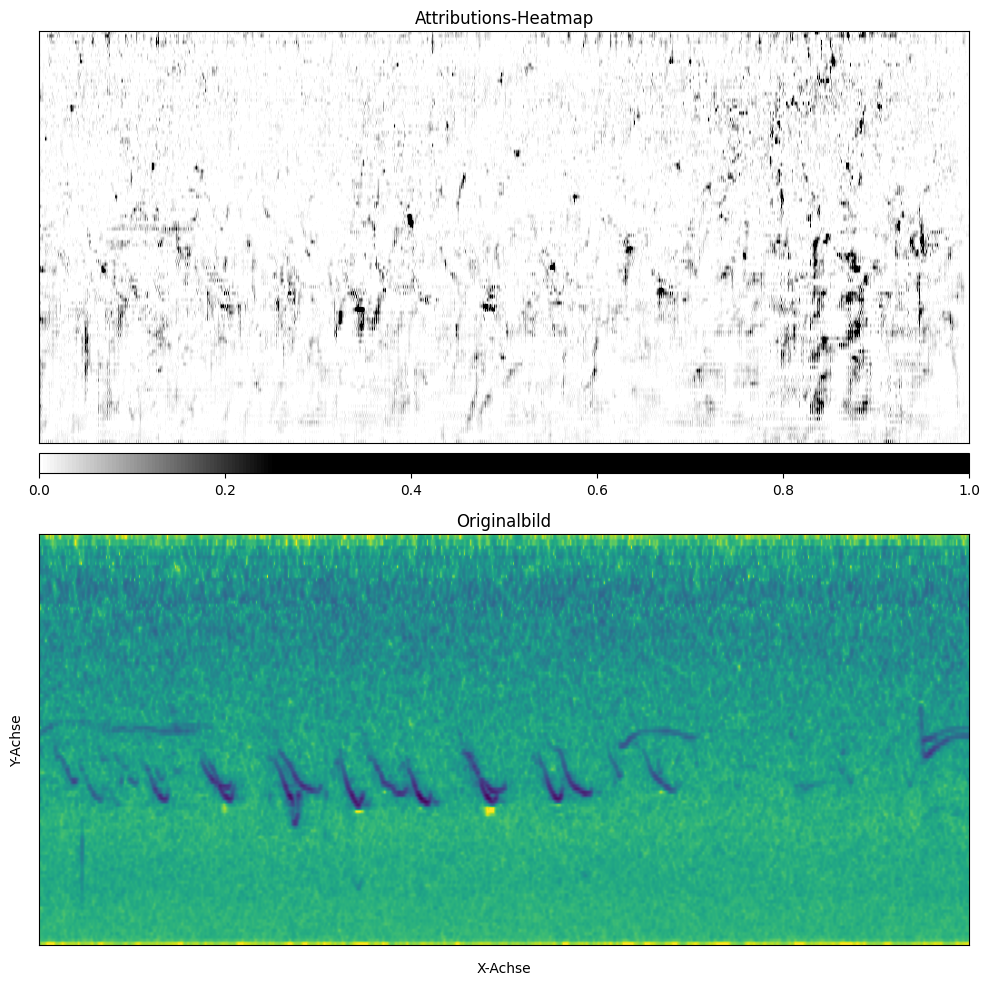

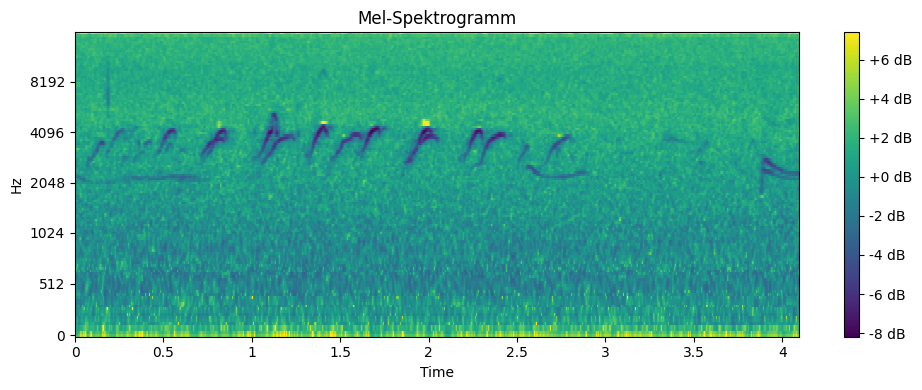

In [80]:
# 2.3 Visualisierung der Attributionswerte

# Erstellung einer benutzerdefinierten Farbkarte
default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], 
                                                 N=256)

# Visualisierung der Attributionswerte: 

# Figur und Subplots erstellen
fig, axs = plt.subplots(2, 1, figsize=(10, 10))  # 2 Zeilen für 2 Plots, 1 Spalte

# Heatmap der Attributionswerte visualisieren
viz.visualize_image_attr(attributions_ig_expanded,
                         input.squeeze().cpu().detach().numpy(),
                         method="heat_map",
                         sign="positive",
                         use_pyplot=False,
                         plt_fig_axis=(fig, axs[0]),
                         cmap=default_cmap,
                         outlier_perc=1,
                         show_colorbar=True)
axs[0].title.set_text('Attributions-Heatmap')
axs[0].set_aspect('auto')


# Originalbild visualisieren
viz.visualize_image_attr(None,
                         input.squeeze().cpu().detach().numpy(),
                         method="original_image",
                         use_pyplot=False,
                         plt_fig_axis=(fig, axs[1]),
                         cmap=default_cmap,
                         show_colorbar=True)
axs[1].title.set_text('Originalbild')
axs[1].set_aspect('auto')

# Setze die Achsenbeschriftungen für das Originalbild
axs[1].set_xlabel('X-Achse')  # Ersetze 'X-Achse' mit einer passenden Beschriftung
axs[1].set_ylabel('Y-Achse')  # Ersetze 'Y-Achse' mit einer passenden Beschriftung



plt.tight_layout()
plt.show()

# Spektrogramm
show_spektrogrammm2(first_example_np, sample_rate=sample_rate, hop_length=hop_length, n_fft=n_fft)

In [88]:
input = np.random.rand(10, 10, 3) # input ist ein mit zufälligen zahlen zwicshen 0 und 1 initialisierter np array mit 10 arrays mit jeweils 10 arrays mit je 3 Werten
# print(input)  # [[[0.8379178  0.65078754 0.49306238]  [0.55092165 0.71386188 ... 
#    np.random.rand(10, 10, 3) erzeugt einen Array mit drei Dimensionen.
#    Die erste Dimension hat eine Länge von 10, was bedeutet, dass es 10 Unterarrays gibt.
#    Jeder dieser 10 Unterarrays hat ebenfalls 10 Unterarrays (zweite Dimension).
#    Jeder der Unterarrays in der zweiten Dimension hat 3 Elemente (dritte Dimension).
#    Jedes Element in diesen Arrays ist eine zufällige Zahl zwischen 0 und 1, generiert aus einer gleichverteilten Zufallsverteilung.

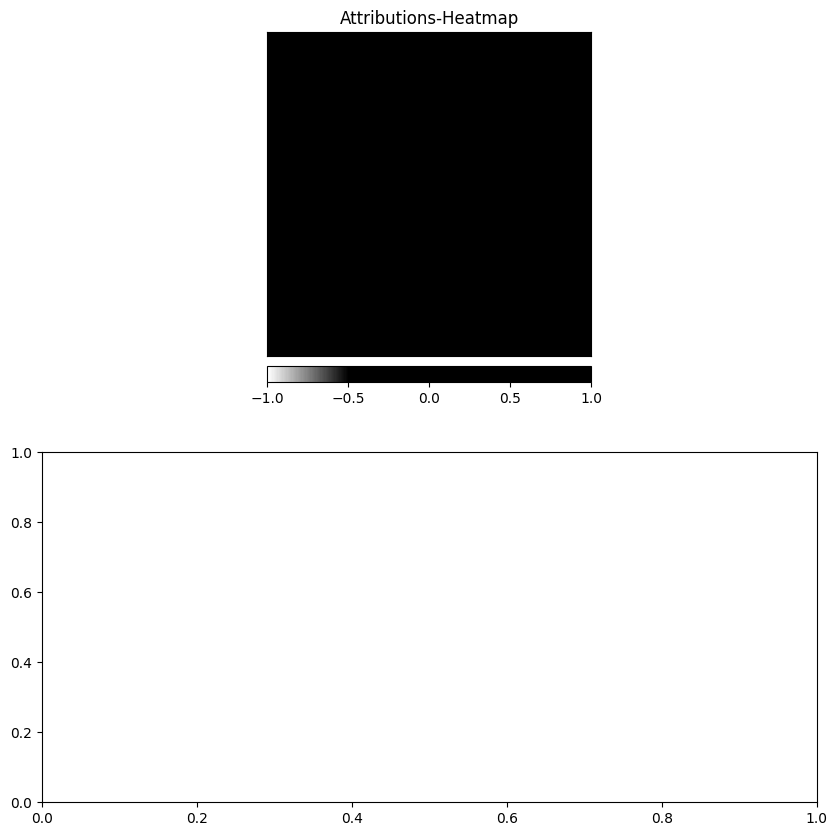

<Figure size 640x480 with 0 Axes>

In [84]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
from captum.attr import visualization as viz  # Korrekter Import für Visualisierungsfunktionen

# Angenommene Daten
input = np.random.rand(10, 10, 3)  # Beispiel-Input
attributions_ig_expanded = np.random.rand(10, 10)  # Beispiel-Attributionen

# Hinzufügen einer dritten Dimension zum Attributions-Array
attributions_ig_expanded = attributions_ig_expanded[:, :, np.newaxis]

# Erstellung einer benutzerdefinierten Farbkarte
default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'), 
                                                  (0.25, '#000000'), 
                                                  (1, '#000000')], 
                                                 N=256)

# Figur und Subplots erstellen
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

# Heatmap der Attributionswerte visualisieren
viz.visualize_image_attr(attributions_ig_expanded,
                         input.squeeze(),  # Beispiel: ersten Tensor benutzen und Dimension reduzieren
                         method="heat_map",
                         sign="all",
                         show_colorbar=True,
                         title="Attributions-Heatmap",
                         plt_fig_axis=(fig, axs[0]),
                         cmap=default_cmap)
axs[0].set_aspect('auto')
# Achsenbeschriftungen setzen
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Frequency (Hz)')

# Originalbild visualisieren
viz.visualize_image_attr(None,
                         input.squeeze(),  # Beispiel: ersten Tensor benutzen und Dimension reduzieren
                         method="original_image",
                         show_colorbar=True,
                         title="Originalbild",
                         plt_fig_axis=(fig, axs[1]),
                         cmap=default_cmap)
axs[1].set_aspect('auto')
# Achsenbeschriftungen setzen
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Frequency (Hz)')

plt.tight_layout()
plt.show()

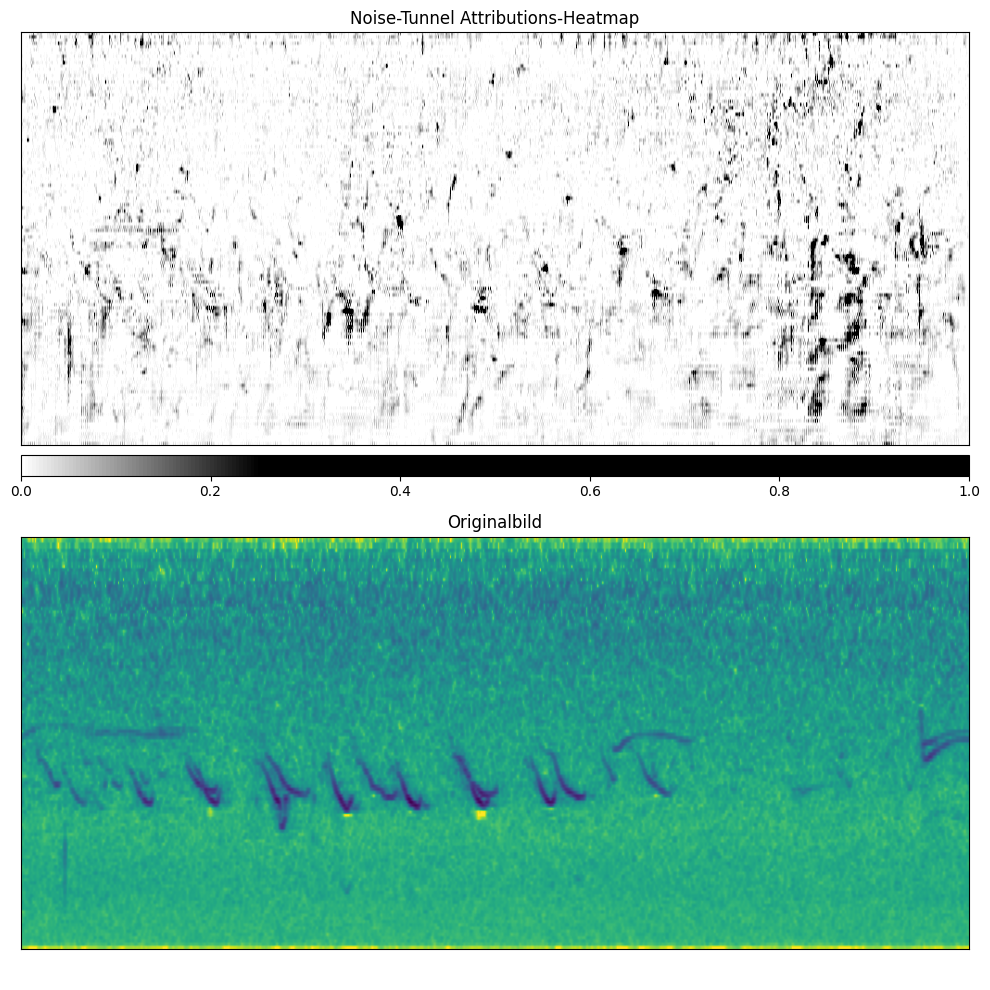

In [37]:
# 2.4 Anwendung von Noise Tunnel auf Integrated Gradients: fügt Rauschen in die Eingabedaten ein
# dauert länger

#  Erstellen einer Noise-Tunnel Instanz:
noise_tunnel = NoiseTunnel(integrated_gradients)

# input ist der tensor des schwanenfotos, pred_label_idx= 99
attributions_ig_nt = noise_tunnel.attribute(input, nt_samples=10, nt_type='smoothgrad_sq', target=pred_label_idx)
# print(attributions_ig_nt)


# Visualisierung der Noise Tunnel Attributionswerte: 

# Figur und Subplots erstellen
fig, axs = plt.subplots(2, 1, figsize=(10, 10))  # 2 Zeilen für 2 Plots, 1 Spalte

# Heatmap der Attributionswerte visualisieren
viz.visualize_image_attr(attributions_ig_expanded,
                         input.squeeze().cpu().detach().numpy(),
                         method="heat_map",
                         sign="positive",
                         use_pyplot=False,
                         plt_fig_axis=(fig, axs[0]),
                         cmap=default_cmap,
                         show_colorbar=True)
axs[0].title.set_text('Noise-Tunnel Attributions-Heatmap')
axs[0].set_aspect('auto')


# Originalbild visualisieren
viz.visualize_image_attr(None,
                         input.squeeze().cpu().detach().numpy(),
                         method="original_image",
                         use_pyplot=False,
                         plt_fig_axis=(fig, axs[1]),
                         cmap=default_cmap,
                         show_colorbar=True)
axs[1].title.set_text('Originalbild')
axs[1].set_aspect('auto')


plt.tight_layout()
plt.show()




In [ ]:
# 2.5 GradientShap

# Setzen der Zufallssamenfür PyTorch und NumPy (sorgt für Reproduzierbarkeit):
torch.manual_seed(0)
np.random.seed(0)

# Erstellen einer GradientShap-Instanz:
# GradientShap ist eine Erklärungsmethode, die auf der Idee der Shapley-Werte basiert, aber Gradienten verwendet
gradient_shap = GradientShap(model)

# Defining baseline distribution of images
# baseline-Verteilung besteht aus 2 Eingabebildern: input*0 (also schwarzes Bild) und input*1 (unveränderter schwan)
rand_img_dist = torch.cat([input * 0, input * 1])

# Berechnung der Attributionswerte mit GradientShap:
attributions_gs = gradient_shap.attribute(input,
                                          n_samples=50,
                                          stdevs=0.0001,
                                          baselines=rand_img_dist,
                                          target=pred_label_idx)
# print("attributions_gs", attributions_gs)  # tensor([[[[-2.8246e-05,  2.7142e-04,  3.7


In [ ]:
# 2.5.a Visualisierung der GradientShap Attributionswerte: 

# Figur und Subplots erstellen
fig, axs = plt.subplots(2, 1, figsize=(10, 10))  # 2 Zeilen für 2 Plots, 1 Spalte

# Heatmap der Attributionswerte visualisieren
viz.visualize_image_attr(attributions_ig_expanded,
                         input.squeeze().cpu().detach().numpy(),
                         method="heat_map",
                         sign="absolute_value",
                         use_pyplot=False,
                         plt_fig_axis=(fig, axs[0]),
                         cmap=default_cmap,
                         show_colorbar=True)
axs[0].title.set_text('GradientShap Attributions-Heatmap')
axs[0].set_aspect('auto')


# Originalbild visualisieren
viz.visualize_image_attr(None,
                         input.squeeze().cpu().detach().numpy(),
                         method="original_image",
                         use_pyplot=False,
                         plt_fig_axis=(fig, axs[1]),
                         cmap=default_cmap,
                         show_colorbar=True)
axs[1].title.set_text('Originalbild')
axs[1].set_aspect('auto')


plt.tight_layout()
plt.show()


## 3- Occlusion-based attribution

Verdeckung von Bildteilen

Abschätzen, welche Bereiche des Bildes für die Entscheidung des Klassifikators kritisch sind, indem wir sie verdecken und quantifizieren, wie sich die Entscheidung ändert.

Technik, die aufzeigt, wie das Entfernen (oder "Verdecken") von Teilen der Eingabedaten die Vorhersage des Modells beeinflusst. Diese Methode hilft dabei zu verstehen, welche Bereiche oder Merkmale der Eingabedaten für die Vorhersagen des Modells besonders wichtig sind.
Kleines verdeckendes Fenster wird über das Bild bewegt. Jedes Mal macht das Modell eine Vorhersage. Die Veränderung des Prediction Scores zeigt, wie wichtig der verdeckte Teil ist.


•	Erstellen einer Occlusion-Instanz

    Berechnung der Attributionswerte für den „attributions_occ“-Tensor
    Visualisierung

•	Erneutes Erstellen der Occlusion-Instanz mit größeren Windows

    Berechnung der Attributionswerte, diesmal strides=(3, 50, 50), sliding_window_shapes=(3, 60, 60)
    Visualisierung


In [ ]:
print(input)

In [ ]:
# 3.1 Erstellen einer Occlusion-Instanz:
# dauert länger

occlusion = Occlusion(model)

# Attributionsberechnung:
attributions_occ = occlusion.attribute(input,
                                       strides = (1, 8, 8),
                                       target=pred_label_idx,
                                       sliding_window_shapes=(1,15, 15),
                                       baselines=0)
print(attributions_occ)

In [ ]:
# 2.2 Umformung und Umwandlung des attributions_ig Tensors in einen NumPy-Array

attributions_occ_expanded = np.expand_dims(attributions_ig.squeeze().cpu().detach().numpy(), axis=2)
# print(attributions_occ_expanded)  # [[[ 2.21424055e-05]   [-8.83162433e-05]

In [ ]:
# 3.2 Verwenden einer Visualisierungsfunktion, um mehrere Bildattribute gleichzeitig zu visualisieren


# Figur und Subplots erstellen
fig, axs = plt.subplots(3, 1, figsize=(10, 15))  # 3 Zeilen für 3 Plots, 1 Spalte


# Erste Heatmap der Attributionswerte visualisieren (z.B. positive Attributionen)
viz.visualize_image_attr(attributions_occ_expanded, 
                         input.squeeze().cpu().detach().numpy(),
                         method="heat_map",
                         sign="positive",
                         use_pyplot=False,
                         plt_fig_axis=(fig, axs[0]),
                         # cmap='inferno',
                         show_colorbar=True,
                         outlier_perc=2)
axs[0].set_title('Positive Attributions-Heatmap')
axs[0].set_aspect('auto')

# Zweite Heatmap der Attributionswerte visualisieren (z.B. negative Attributionen)
# Stelle sicher, dass du hier eine andere Attribution verwendest, falls verfügbar
viz.visualize_image_attr(attributions_occ_expanded,
                         input.squeeze().cpu().detach().numpy(),
                         method="heat_map",
                         sign="negative",  # Annahme, dass dies negative Attributionen darstellt
                         use_pyplot=False,
                         plt_fig_axis=(fig, axs[1]),
                         # cmap='inferno',
                         show_colorbar=True,
                         outlier_perc=2)
axs[1].set_title('Negative Attributions-Heatmap')
axs[1].set_aspect('auto')

# Originalbild visualisieren
viz.visualize_image_attr(None,
                         input.squeeze().cpu().detach().numpy(),
                         method="original_image",
                         use_pyplot=False,
                         plt_fig_axis=(fig, axs[2]),
                         cmap='gray',  # 'gray' funktioniert gut für Graustufenbilder
                         show_colorbar=False)  # Farbleiste ist für das Originalbild normalerweise nicht nötig
axs[2].set_title('Originalbild')
axs[2].set_aspect('auto')

plt.tight_layout()
plt.show()

In [ ]:
# 3.3 Versuch, den plot in extra-Fenster anzuzeigen

import plotly.express as px
import numpy as np
import torch

import plotly.io as pio
pio.renderers.default = 'notebook'


# Angenommen, attributions_ig_expanded ist dein Tensor mit Attributionswerten
# und 'input' ist dein Eingabebild

# Bereite die Attributionsdaten vor
attributions = attributions_ig_expanded.squeeze()  # Stelle sicher, dass es ein 2D-Array ist
input_image = input.squeeze().cpu().detach().numpy()  # Bereite das Eingabebild vor

# Du möchtest vielleicht die Attributionswerte auf das Eingabebild auftragen
# Hier ein einfaches Beispiel, wie man die Attributionswerte normalisieren und auf das Bild anwenden könnte
# Beachte: Du musst dies an deinen spezifischen Fall anpassen
attributions_normalized = (attributions - attributions.min()) / (attributions.max() - attributions.min())
heatmap = np.uint8(255 * attributions_normalized)  # Konvertiere zu einem 8-Bit-Array für die Darstellung

# Verwende Plotly, um das Bild anzuzeigen
fig = px.imshow(heatmap, color_continuous_scale='Inferno')  # 'Inferno' oder eine andere Farbskala deiner Wahl
fig.show()

In [ ]:
# 3.3 Okklusion mit einem größeren Sliding Window


occlusion = Occlusion(model)

attributions_occ = occlusion.attribute(input,
                                       strides = (1, 127, 127),
                                       target=pred_label_idx,
                                       sliding_window_shapes=(1,128, 128),
                                       baselines=0)
"""
_ = viz.visualize_image_attr_multiple(
        attributions_ig_expanded,  # Verwende das erweiterte Attributions-Array
        input.squeeze().cpu().detach().numpy(),  # Verwende transformed_img direkt, ohne Transposition
        ["heat_map"],
        ["positive"],
        #["original_image", "heat_map"],
        #["all", "positive"],
        show_colorbar=True,
        outlier_perc=2)
"""

# Figur und Subplots erstellen
fig, axs = plt.subplots(2, 1, figsize=(10, 15))  # 3 Zeilen für 3 Plots, 1 Spalte

# Erste Heatmap der Attributionswerte visualisieren (z.B. positive Attributionen)

# attributions_ig_expanded? TODO
viz.visualize_image_attr(attributions_occ_expanded,
                         input.squeeze().cpu().detach().numpy(),
                         method="heat_map",
                         sign="positive",
                         use_pyplot=False,
                         plt_fig_axis=(fig, axs[0]),
                         # cmap='inferno',
                         show_colorbar=True,
                         outlier_perc=2)
axs[0].set_title('Occlusion-Heatmap mit einem größeren Sliding Window')
axs[0].set_aspect('auto')


# Originalbild visualisieren
viz.visualize_image_attr(None,
                         input.squeeze().cpu().detach().numpy(),
                         method="original_image",
                         use_pyplot=False,
                         plt_fig_axis=(fig, axs[1]),
                         cmap='gray',  # 'gray' funktioniert gut für Graustufenbilder
                         show_colorbar=False)  # Farbleiste ist für das Originalbild normalerweise nicht nötig
axs[1].set_title('Originalbild')
axs[1].set_aspect('auto')

plt.tight_layout()
plt.show()

In [ ]:
input.shape

 ## 4- LRP-based attribution

Wie tragen die Eingabemerkmale (z.B. Pixel eines Bildes) zur Vorhersage des Modells bei?

LRP basiert auf der Idee, die Relevanz, die ein Ausgabeneuron (zum Beispiel die Vorhersage eines bestimmten Labels) hat, rückwärts durch das Netzwerk zu den Eingabeneuronen zu propagieren. Auf diese Weise kann bestimmt werden, welche Teile der Eingabe für die Vorhersage des Netzwerks am wichtigsten sind.

•	Vortrainiertes Modell laden
Modell in Evaluierungsmodus setzen
LRP-Instanz erstellen: lrp = LRP(model)
Tensor mit Attributionswerten auf dem Spektrogramm und Label berechnen

•	Visualisieren

•	LRP mit verschiedenen Propagation Rules:

Extrahieren der Modellschichten
Anzahl der Schichten bestimmen
spezifische LRP-Regeln zuweisen

LRP-Instanz erstellen und Attributionswerte berechnen


•	Visualisieren


In [ ]:
# 4.1  LRP-Instanz erstellen und Attributionswerte berechnen

# Modell in den Evaluierungsmodus setzen:
# model.eval()

# LRP-Instanz erstellen (default ist Epsilon-Rule):
# lrp = LRP(model)
# print("lrp", lrp)

# Attributionswerte berechnen:
# attributions_lrp = lrp.attribute(
#         input, 
#         target=pred_label_idx)


Funktioniert nicht, gibt:
TypeError: Module of type <class 'torch.nn.modules.activation.SiLU'> has no rule defined and nodefault rule exists for this module type. Please, set a ruleexplicitly for this module and assure that it is appropriatefor this type of layer.

Grund: 
EfficientNet verwendet SiLU, und LRP kann nicht mit SiLU umgehen

Es gäbe für Efficientnet-B0 einen Wrapper:
    https://github.com/AlexBinder/LRP_EfficientnetB0

# 5 Saliency

In [ ]:
"""
def attribute_image_features(algorithm, input, **kwargs):
    model.zero_grad()
    tensor_attributions = algorithm.attribute(input,
                                              target=labels[ind],
                                              **kwargs
                                             )
    
    return tensor_attributions
"""

In [ ]:
"""
from captum.attr import Saliency

saliency = Saliency(model)
grads = saliency.attribute(first_example, target=labels[first_example].item())
grads = np.transpose(grads.squeeze().cpu().detach().numpy(), (1, 2, 0))
"""